In [1]:
# ==================================================================
# Section 1: Imports and Configuration
# ==================================================================
import os
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA is available: {torch.cuda.is_available()}")

# --- Define File Paths ---
base_dir = "C:/Users/pxc02/OneDrive/Desktop/archive/USA_segmentation"
rgb_image_dir = os.path.join(base_dir, "RGB_images")
nrg_image_dir = os.path.join(base_dir, "NRG_images")
mask_dir = os.path.join(base_dir, "masks")

# --- Verify Paths ---
print(f"RGB Image directory: {rgb_image_dir}")
print(f"NRG Image directory: {nrg_image_dir}")
print(f"Mask directory: {mask_dir}")


PyTorch Version: 2.5.1
CUDA is available: True
RGB Image directory: C:/Users/pxc02/OneDrive/Desktop/archive/USA_segmentation\RGB_images
NRG Image directory: C:/Users/pxc02/OneDrive/Desktop/archive/USA_segmentation\NRG_images
Mask directory: C:/Users/pxc02/OneDrive/Desktop/archive/USA_segmentation\masks


In [2]:
# ==================================================================
# Section 2: Prepare and Split the Dataset
# ==================================================================
# We use the RGB filenames as the master list
image_files = sorted([f for f in os.listdir(rgb_image_dir) if f.endswith('.png')])
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

print(f"Total images: {len(image_files)}")
print(f"Number of training images: {len(train_files)}")
print(f"Number of validation images: {len(val_files)}")



Total images: 444
Number of training images: 355
Number of validation images: 89


In [3]:
# ==================================================================
# Section 3: Custom Dataset Class for 6-Channel Input
# ==================================================================
class MultiModalDataset(Dataset):
    """Custom Dataset for loading both RGB and NRG images."""
    def __init__(self, image_files, rgb_dir, nrg_dir, mask_dir, transform=None, mask_transform=None):
        self.image_files = image_files
        self.rgb_dir = rgb_dir
        self.nrg_dir = nrg_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get master filename (based on RGB)
        rgb_img_name = self.image_files[idx]
        
        # Construct other filenames
        nrg_img_name = rgb_img_name.replace("RGB_", "NRG_")
        mask_name = rgb_img_name.replace("RGB_", "mask_")
        
        # Open all three images
        rgb_path = os.path.join(self.rgb_dir, rgb_img_name)
        nrg_path = os.path.join(self.nrg_dir, nrg_img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        rgb_image = Image.open(rgb_path).convert("RGB")
        nrg_image = Image.open(nrg_path).convert("RGB") # Keep convert("RGB") to ensure 3 channels
        mask = Image.open(mask_path).convert("L")

        # Apply transformations to RGB and NRG images separately
        if self.transform:
            rgb_tensor = self.transform(rgb_image)
            nrg_tensor = self.transform(nrg_image)
        
        # Combine the two 3-channel tensors into one 6-channel tensor
        combined_tensor = torch.cat([rgb_tensor, nrg_tensor], dim=0)

        if self.mask_transform:
            mask = self.mask_transform(mask)
            mask = (mask > 0.5).long()
            
        # We return the combined tensor for model input, and the original RGB for visualization
        return combined_tensor, self.transform(rgb_image), mask


In [4]:
# ==================================================================
# Section 4: Define Data Transforms and DataLoaders
# ==================================================================
IMG_SIZE = 256

image_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

train_dataset = MultiModalDataset(train_files, rgb_image_dir, nrg_image_dir, mask_dir, image_transform, mask_transform)
val_dataset = MultiModalDataset(val_files, rgb_image_dir, nrg_image_dir, mask_dir, image_transform, mask_transform)

BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("6-Channel DataLoaders created successfully.")


6-Channel DataLoaders created successfully.


In [5]:
# ==================================================================
# Section 5: Define and Modify the DeepLabv3 Model for 6-Channel Input
# ==================================================================
NUM_CLASSES = 2
model = deeplabv3_resnet50(weights='DeepLabV3_ResNet50_Weights.DEFAULT')

# --- MODIFICATION: Adapt the first layer for 6-channel input ---
# Get the original first convolution layer
original_conv1 = model.backbone.conv1

# Create a new convolution layer with 6 input channels
new_conv1 = nn.Conv2d(6, # New number of input channels
                      original_conv1.out_channels, 
                      kernel_size=original_conv1.kernel_size, 
                      stride=original_conv1.stride, 
                      padding=original_conv1.padding, 
                      bias=(original_conv1.bias is not None))

# Replace the original layer with our new 6-channel layer
model.backbone.conv1 = new_conv1

# Adapt the final classifier layer as before
model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=(1, 1), stride=(1, 1))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("Model modified for 6-channel input and moved to device:", device)


Model modified for 6-channel input and moved to device: cuda


In [6]:
# ==================================================================
# Section 6: Helper Function for Metric Calculation
# ==================================================================
def calculate_foreground_iou(outputs, masks, foreground_class_index=1):
    preds = torch.argmax(outputs, dim=1)
    preds_np = preds.cpu().numpy()
    masks_np = masks.cpu().numpy()
    c = foreground_class_index
    intersection = np.sum((preds_np == c) & (masks_np == c))
    union = np.sum((preds_np == c) | (masks_np == c))
    if union == 0: return np.nan
    return intersection / union


In [7]:
# ==================================================================
# Section 7: Train and Validate the 6-Channel Model
# ==================================================================
NUM_EPOCHS = 100
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    # MODIFICATION: Unpack data (ignore the visualization image during training)
    for combined_input, _, masks in train_progress:
        combined_input, masks = combined_input.to(device), masks.squeeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(combined_input)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    iou_scores = []
    with torch.no_grad():
        val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
        # MODIFICATION: Unpack data
        for combined_input, _, masks in val_progress:
            combined_input, masks_squeezed = combined_input.to(device), masks.squeeze(1).to(device)
            outputs = model(combined_input)['out']
            loss = criterion(outputs, masks_squeezed)
            val_loss += loss.item()
            iou = calculate_foreground_iou(outputs, masks_squeezed)
            iou_scores.append(iou)

    avg_val_loss = val_loss / len(val_loader)
    avg_iou = np.nanmean(iou_scores)
    
    print(f"Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | IoU: {avg_iou:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'deeplabv3_rgb_nrg_best_model.pth')
        print(f"  -> Combined Model saved with new best validation loss: {best_val_loss:.4f}")

print("Finished Training")


Epoch 1/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 001 | Train Loss: 0.3528 | Val Loss: 0.1967 | IoU: 0.0054
  -> Combined Model saved with new best validation loss: 0.1967


Epoch 2/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 2/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 002 | Train Loss: 0.1513 | Val Loss: 0.1219 | IoU: 0.0000
  -> Combined Model saved with new best validation loss: 0.1219


Epoch 3/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 3/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 003 | Train Loss: 0.1161 | Val Loss: 0.1038 | IoU: 0.0000
  -> Combined Model saved with new best validation loss: 0.1038


Epoch 4/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 4/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 004 | Train Loss: 0.1002 | Val Loss: 0.0926 | IoU: 0.0036
  -> Combined Model saved with new best validation loss: 0.0926


Epoch 5/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 5/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 005 | Train Loss: 0.0867 | Val Loss: 0.0821 | IoU: 0.0282
  -> Combined Model saved with new best validation loss: 0.0821


Epoch 6/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 6/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 006 | Train Loss: 0.0770 | Val Loss: 0.0738 | IoU: 0.0668
  -> Combined Model saved with new best validation loss: 0.0738


Epoch 7/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 7/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 007 | Train Loss: 0.0699 | Val Loss: 0.0700 | IoU: 0.0749
  -> Combined Model saved with new best validation loss: 0.0700


Epoch 8/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 8/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 008 | Train Loss: 0.0644 | Val Loss: 0.0658 | IoU: 0.1565
  -> Combined Model saved with new best validation loss: 0.0658


Epoch 9/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 9/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 009 | Train Loss: 0.0593 | Val Loss: 0.0642 | IoU: 0.1507
  -> Combined Model saved with new best validation loss: 0.0642


Epoch 10/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 10/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 010 | Train Loss: 0.0562 | Val Loss: 0.0626 | IoU: 0.1450
  -> Combined Model saved with new best validation loss: 0.0626


Epoch 11/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 11/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 011 | Train Loss: 0.0530 | Val Loss: 0.0614 | IoU: 0.1727
  -> Combined Model saved with new best validation loss: 0.0614


Epoch 12/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 12/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 012 | Train Loss: 0.0497 | Val Loss: 0.0617 | IoU: 0.1330


Epoch 13/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 13/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 013 | Train Loss: 0.0465 | Val Loss: 0.0607 | IoU: 0.1648
  -> Combined Model saved with new best validation loss: 0.0607


Epoch 14/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 14/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 014 | Train Loss: 0.0446 | Val Loss: 0.0612 | IoU: 0.1801


Epoch 15/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 15/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 015 | Train Loss: 0.0426 | Val Loss: 0.0608 | IoU: 0.2010


Epoch 16/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 16/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 016 | Train Loss: 0.0399 | Val Loss: 0.0623 | IoU: 0.1697


Epoch 17/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 17/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 017 | Train Loss: 0.0380 | Val Loss: 0.0586 | IoU: 0.2164
  -> Combined Model saved with new best validation loss: 0.0586


Epoch 18/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 18/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 018 | Train Loss: 0.0359 | Val Loss: 0.0603 | IoU: 0.1857


Epoch 19/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 19/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 019 | Train Loss: 0.0349 | Val Loss: 0.0583 | IoU: 0.2106
  -> Combined Model saved with new best validation loss: 0.0583


Epoch 20/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 20/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 020 | Train Loss: 0.0332 | Val Loss: 0.0610 | IoU: 0.2081


Epoch 21/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 21/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 021 | Train Loss: 0.0321 | Val Loss: 0.0619 | IoU: 0.2210


Epoch 22/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 22/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 022 | Train Loss: 0.0318 | Val Loss: 0.0616 | IoU: 0.1966


Epoch 23/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 23/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 023 | Train Loss: 0.0303 | Val Loss: 0.0591 | IoU: 0.2289


Epoch 24/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 24/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 024 | Train Loss: 0.0289 | Val Loss: 0.0603 | IoU: 0.2357


Epoch 25/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 25/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 025 | Train Loss: 0.0283 | Val Loss: 0.0608 | IoU: 0.2456


Epoch 26/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 26/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 026 | Train Loss: 0.0275 | Val Loss: 0.0636 | IoU: 0.2261


Epoch 27/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 27/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 027 | Train Loss: 0.0262 | Val Loss: 0.0639 | IoU: 0.2210


Epoch 28/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 28/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 028 | Train Loss: 0.0255 | Val Loss: 0.0670 | IoU: 0.1969


Epoch 29/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 29/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 029 | Train Loss: 0.0252 | Val Loss: 0.0643 | IoU: 0.2310


Epoch 30/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 30/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 030 | Train Loss: 0.0248 | Val Loss: 0.0661 | IoU: 0.2218


Epoch 31/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 31/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 031 | Train Loss: 0.0241 | Val Loss: 0.0652 | IoU: 0.2439


Epoch 32/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 32/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 032 | Train Loss: 0.0238 | Val Loss: 0.0680 | IoU: 0.2418


Epoch 33/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 33/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 033 | Train Loss: 0.0233 | Val Loss: 0.0670 | IoU: 0.2325


Epoch 34/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 34/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 034 | Train Loss: 0.0227 | Val Loss: 0.0679 | IoU: 0.2293


Epoch 35/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 35/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 035 | Train Loss: 0.0226 | Val Loss: 0.0695 | IoU: 0.2320


Epoch 36/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 36/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 036 | Train Loss: 0.0220 | Val Loss: 0.0687 | IoU: 0.2407


Epoch 37/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 37/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 037 | Train Loss: 0.0219 | Val Loss: 0.0704 | IoU: 0.2345


Epoch 38/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 38/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 038 | Train Loss: 0.0216 | Val Loss: 0.0698 | IoU: 0.2486


Epoch 39/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 39/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 039 | Train Loss: 0.0215 | Val Loss: 0.0702 | IoU: 0.2485


Epoch 40/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 40/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 040 | Train Loss: 0.0212 | Val Loss: 0.0714 | IoU: 0.2324


Epoch 41/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 41/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 041 | Train Loss: 0.0207 | Val Loss: 0.0710 | IoU: 0.2432


Epoch 42/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 42/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 042 | Train Loss: 0.0206 | Val Loss: 0.0720 | IoU: 0.2475


Epoch 43/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 43/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 043 | Train Loss: 0.0205 | Val Loss: 0.0706 | IoU: 0.2483


Epoch 44/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 44/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 044 | Train Loss: 0.0204 | Val Loss: 0.0737 | IoU: 0.2510


Epoch 45/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 45/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 045 | Train Loss: 0.0204 | Val Loss: 0.0808 | IoU: 0.2167


Epoch 46/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 46/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 046 | Train Loss: 0.0205 | Val Loss: 0.0812 | IoU: 0.2087


Epoch 47/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 47/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 047 | Train Loss: 0.0207 | Val Loss: 0.0735 | IoU: 0.2445


Epoch 48/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 48/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 048 | Train Loss: 0.0204 | Val Loss: 0.0768 | IoU: 0.2622


Epoch 49/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 49/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 049 | Train Loss: 0.0200 | Val Loss: 0.0744 | IoU: 0.2522


Epoch 50/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 50/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 050 | Train Loss: 0.0196 | Val Loss: 0.0807 | IoU: 0.2278


Epoch 51/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 51/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 051 | Train Loss: 0.0194 | Val Loss: 0.0762 | IoU: 0.2515


Epoch 52/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 52/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 052 | Train Loss: 0.0193 | Val Loss: 0.0806 | IoU: 0.2213


Epoch 53/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 53/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 053 | Train Loss: 0.0193 | Val Loss: 0.0828 | IoU: 0.2365


Epoch 54/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 54/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 054 | Train Loss: 0.0192 | Val Loss: 0.0823 | IoU: 0.2516


Epoch 55/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 55/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 055 | Train Loss: 0.0192 | Val Loss: 0.0829 | IoU: 0.2516


Epoch 56/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 56/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 056 | Train Loss: 0.0193 | Val Loss: 0.0808 | IoU: 0.2489


Epoch 57/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 57/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 057 | Train Loss: 0.0205 | Val Loss: 0.0785 | IoU: 0.2343


Epoch 58/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 58/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 058 | Train Loss: 0.0237 | Val Loss: 0.0845 | IoU: 0.1714


Epoch 59/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 59/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 059 | Train Loss: 0.0260 | Val Loss: 0.0779 | IoU: 0.2142


Epoch 60/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 60/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 060 | Train Loss: 0.0226 | Val Loss: 0.0793 | IoU: 0.2436


Epoch 61/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 61/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 061 | Train Loss: 0.0208 | Val Loss: 0.0767 | IoU: 0.2387


Epoch 62/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 62/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 062 | Train Loss: 0.0195 | Val Loss: 0.0809 | IoU: 0.2462


Epoch 63/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 63/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 063 | Train Loss: 0.0188 | Val Loss: 0.0799 | IoU: 0.2465


Epoch 64/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 64/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 064 | Train Loss: 0.0185 | Val Loss: 0.0847 | IoU: 0.2429


Epoch 65/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 65/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 065 | Train Loss: 0.0182 | Val Loss: 0.0844 | IoU: 0.2418


Epoch 66/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 66/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 066 | Train Loss: 0.0180 | Val Loss: 0.0866 | IoU: 0.2266


Epoch 67/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 67/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 067 | Train Loss: 0.0179 | Val Loss: 0.0868 | IoU: 0.2343


Epoch 68/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 68/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 068 | Train Loss: 0.0178 | Val Loss: 0.0898 | IoU: 0.2200


Epoch 69/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 69/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 069 | Train Loss: 0.0178 | Val Loss: 0.0886 | IoU: 0.2308


Epoch 70/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 70/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 070 | Train Loss: 0.0177 | Val Loss: 0.0859 | IoU: 0.2493


Epoch 71/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 71/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 071 | Train Loss: 0.0176 | Val Loss: 0.0877 | IoU: 0.2480


Epoch 72/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 72/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 072 | Train Loss: 0.0175 | Val Loss: 0.0930 | IoU: 0.2320


Epoch 73/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 73/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 073 | Train Loss: 0.0175 | Val Loss: 0.0941 | IoU: 0.2333


Epoch 74/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 74/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 074 | Train Loss: 0.0174 | Val Loss: 0.0925 | IoU: 0.2262


Epoch 75/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 75/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 075 | Train Loss: 0.0174 | Val Loss: 0.0864 | IoU: 0.2419


Epoch 76/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 76/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 076 | Train Loss: 0.0173 | Val Loss: 0.0908 | IoU: 0.2441


Epoch 77/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 77/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 077 | Train Loss: 0.0173 | Val Loss: 0.0907 | IoU: 0.2419


Epoch 78/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 78/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 078 | Train Loss: 0.0173 | Val Loss: 0.0935 | IoU: 0.2425


Epoch 79/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 79/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 079 | Train Loss: 0.0172 | Val Loss: 0.0936 | IoU: 0.2400


Epoch 80/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 80/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 080 | Train Loss: 0.0172 | Val Loss: 0.0919 | IoU: 0.2480


Epoch 81/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 81/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 081 | Train Loss: 0.0172 | Val Loss: 0.0961 | IoU: 0.2284


Epoch 82/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 82/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 082 | Train Loss: 0.0172 | Val Loss: 0.0911 | IoU: 0.2494


Epoch 83/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 83/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 083 | Train Loss: 0.0172 | Val Loss: 0.0996 | IoU: 0.2332


Epoch 84/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 84/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 084 | Train Loss: 0.0172 | Val Loss: 0.0962 | IoU: 0.2421


Epoch 85/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 85/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 085 | Train Loss: 0.0172 | Val Loss: 0.0926 | IoU: 0.2564


Epoch 86/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 86/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 086 | Train Loss: 0.0171 | Val Loss: 0.0990 | IoU: 0.2501


Epoch 87/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 87/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 087 | Train Loss: 0.0173 | Val Loss: 0.0931 | IoU: 0.2542


Epoch 88/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 88/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 088 | Train Loss: 0.0174 | Val Loss: 0.1078 | IoU: 0.2221


Epoch 89/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 89/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 089 | Train Loss: 0.0183 | Val Loss: 0.1031 | IoU: 0.2084


Epoch 90/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 90/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 090 | Train Loss: 0.0232 | Val Loss: 0.1032 | IoU: 0.2139


Epoch 91/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 91/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 091 | Train Loss: 0.0355 | Val Loss: 0.0798 | IoU: 0.2159


Epoch 92/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 92/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 092 | Train Loss: 0.0240 | Val Loss: 0.0855 | IoU: 0.2248


Epoch 93/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 93/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 093 | Train Loss: 0.0204 | Val Loss: 0.0837 | IoU: 0.2494


Epoch 94/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 94/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 094 | Train Loss: 0.0187 | Val Loss: 0.0861 | IoU: 0.2418


Epoch 95/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 95/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 095 | Train Loss: 0.0181 | Val Loss: 0.0874 | IoU: 0.2477


Epoch 96/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 96/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 096 | Train Loss: 0.0177 | Val Loss: 0.0900 | IoU: 0.2398


Epoch 97/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 97/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 097 | Train Loss: 0.0175 | Val Loss: 0.0941 | IoU: 0.2381


Epoch 98/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 98/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 098 | Train Loss: 0.0174 | Val Loss: 0.0923 | IoU: 0.2476


Epoch 99/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 99/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 099 | Train Loss: 0.0172 | Val Loss: 0.0896 | IoU: 0.2523


Epoch 100/100 [Train]:   0%|          | 0/89 [00:00<?, ?it/s]

Epoch 100/100 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 100 | Train Loss: 0.0171 | Val Loss: 0.0926 | IoU: 0.2542
Finished Training


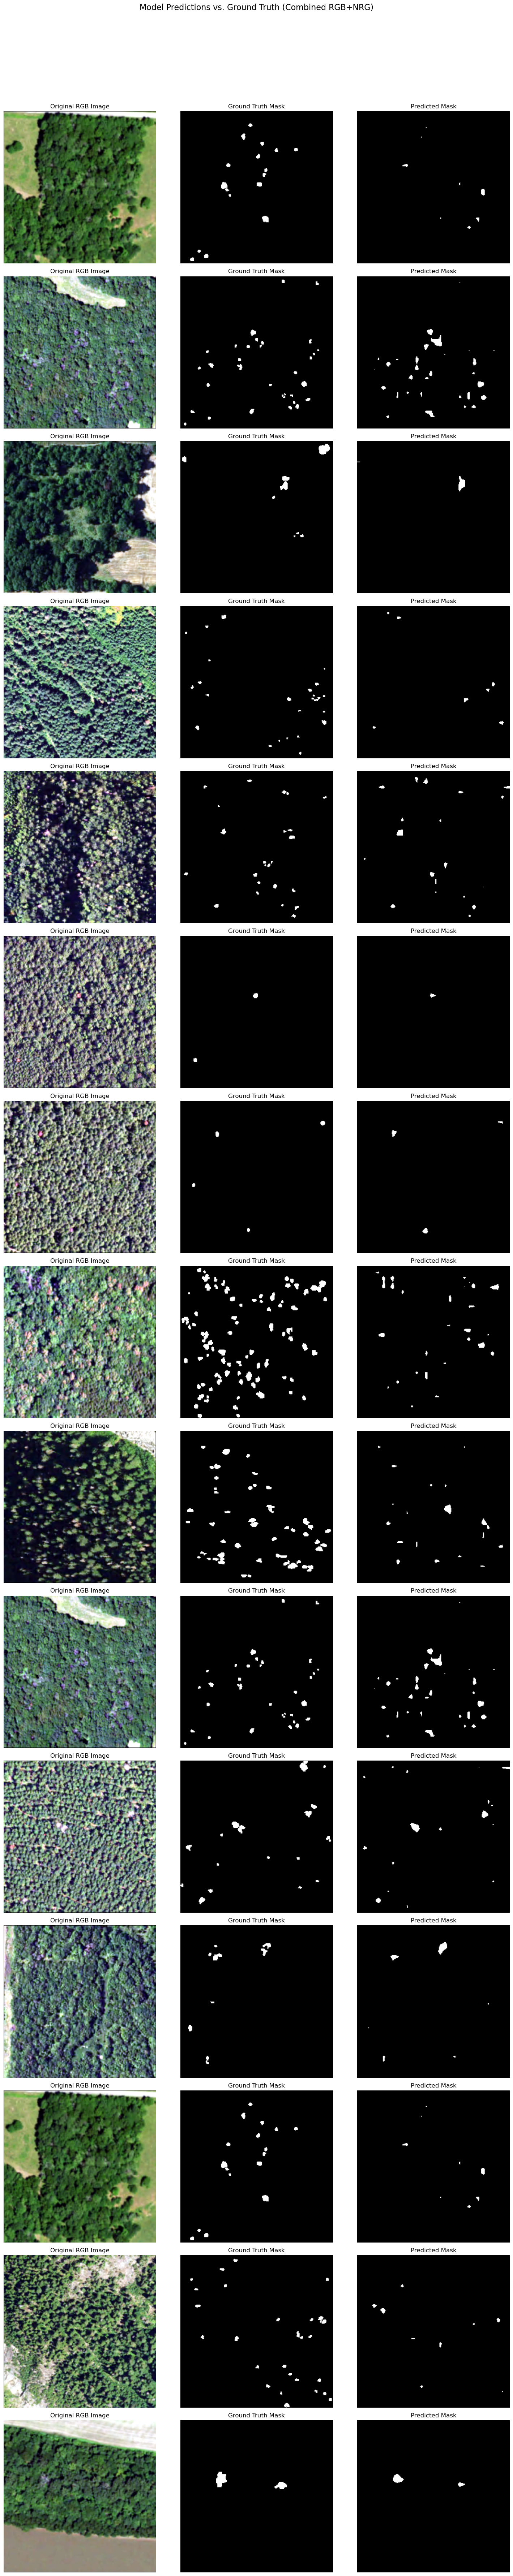

In [9]:
# ==================================================================
# Section 8: Visualize Model Predictions
# ==================================================================
model.load_state_dict(torch.load('deeplabv3_rgb_nrg_best_model.pth', weights_only=True))
model.eval()

def visualize_predictions(dataset, num_samples=3):
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))
    if num_samples == 1:
        axes = np.array([axes])
    fig.suptitle("Model Predictions vs. Ground Truth (Combined RGB+NRG)", fontsize=16)
    
    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        # MODIFICATION: Unpack all three items from the dataset
        combined_input, rgb_for_viz, mask = dataset[idx]
        
        input_tensor = combined_input.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)['out']
            pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

        # Use the separate RGB image for visualization
        img_display = inv_normalize(rgb_for_viz).permute(1, 2, 0).numpy()
        true_mask_display = mask.squeeze().numpy()
        
        axes[i, 0].imshow(img_display)
        axes[i, 0].set_title("Original RGB Image")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(true_mask_display, cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis('off')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run visualization on the validation set
visualize_predictions(val_dataset, num_samples=15)